In [1]:
from inspect import currentframe, getframeinfo
from pathlib import Path

from src.ml.word2vec import SkipGramDataset, SkipGramModel
from torch.utils.data import DataLoader, random_split
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

import tqdm
import torch
import torch.nn as nn

/home/jkaru/.local/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/jkaru/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
input_data = open("../data/text8.tx", "r").read()
corpus = word_tokenize(input_data.lower())[:10000]
word_to_idx = {}
idx_to_word = {}
idx = 0
for i, word in enumerate(corpus):
    if word not in word_to_idx:
        word_to_idx[word] = idx
        idx_to_word[idx] = word
        idx+=1
vocab_size = len(word_to_idx)

In [3]:
print(vocab_size, len(corpus))

2519 10000


In [4]:
mps_device = torch.device('cuda')

In [5]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())

11.7
True


In [6]:
window_size = 4

In [7]:
dataset = SkipGramDataset(corpus, vocab_size, word_to_idx, idx_to_word, window_size=window_size, device=mps_device)
train_set, test_set = random_split(dataset, [0.9, 0.1])
train_loader = DataLoader(train_set, batch_size=2)
test_loader = DataLoader(test_set, batch_size=2)

In [8]:
model = SkipGramModel(vocab_size, hidden_size=300)
model.to(mps_device)

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)

model.to(mps_device)


Let's use 4 GPUs!


DataParallel(
  (module): SkipGramModel(
    (embeddings): Embedding(2519, 300)
    (layer2): Linear(in_features=300, out_features=2519, bias=True)
  )
)

In [9]:
def get_skip_grams(word, model, window_size, word_to_idx, idx_to_word, device = None):
    idx = word_to_idx[word]
    idx = torch.tensor([idx], dtype=torch.long)
    with torch.no_grad():
        output = model(idx)
    _, topi = output[0].topk(2 * window_size)
    topi = topi.squeeze(0).tolist()
    return [idx_to_word[i] for i in topi]

def get_words_sim(model, word1, word2, word_to_idx):
    idx1 = torch.LongTensor([word_to_idx[word1]])
    idx2 = torch.LongTensor([word_to_idx[word2]])
    embeddings1 = model.get_embedding(idx1)
    embeddings2 = model.get_embedding(idx2)
    return cos(embeddings1[0], embeddings2[0])

cos = torch.nn.CosineSimilarity(dim=0)


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
epochs = 200
for e in range(epochs):

    train_loss = 0
    for batch in tqdm.tqdm(train_loader, f"Training model {e}/{epochs}"):
        center_word, context_words = batch
        center_word = center_word.to(mps_device)
        context_words = context_words.to(mps_device)
        model.zero_grad()
        output = model(center_word)
        loss = criterion(output, context_words)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            center_word, context_words = batch
            center_word = center_word.to(mps_device)
            context_words = context_words.to(mps_device)
            outputs = model(center_word)
            loss = criterion(outputs, context_words)
            test_loss += loss.item()
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    print(f"Training loss: {train_loss}")
    print(f"Test loss: {test_loss}")


Training model 0/200: 100%|██████████| 35991/35991 [02:14<00:00, 268.06it/s]


Training loss: 7.061430311226851
Test loss: 6.957967989264086


Training model 1/200: 100%|██████████| 35991/35991 [02:12<00:00, 270.71it/s]


Training loss: 6.232373522203783
Test loss: 7.034549139922605


Training model 2/200:  16%|█▌        | 5585/35991 [00:20<01:51, 273.03it/s]


KeyboardInterrupt: 

In [ ]:
get_skip_grams("revolution", model, window_size, word_to_idx, idx_to_word, device=mps_device)

['[', ']', 'the', 'of', '.', 'and', ',', 'in']

In [ ]:
corpus[:100]

['<',
 'mediawiki',
 'xmlns=',
 "''",
 'http',
 ':',
 '//www.mediawiki.org/xml/export-0.3/',
 "''",
 'xmlns',
 ':',
 'xsi=',
 "''",
 'http',
 ':',
 '//www.w3.org/2001/xmlschema-instance',
 "''",
 'xsi',
 ':',
 'schemalocation=',
 "''",
 'http',
 ':',
 '//www.mediawiki.org/xml/export-0.3/',
 'http',
 ':',
 '//www.mediawiki.org/xml/export-0.3.xsd',
 "''",
 'version=',
 "''",
 '0.3',
 "''",
 'xml',
 ':',
 'lang=',
 "''",
 'en',
 "''",
 '>',
 '<',
 'siteinfo',
 '>',
 '<',
 'sitename',
 '>',
 'wikipedia',
 '<',
 '/sitename',
 '>',
 '<',
 'base',
 '>',
 'http',
 ':',
 '//en.wikipedia.org/wiki/main_page',
 '<',
 '/base',
 '>',
 '<',
 'generator',
 '>',
 'mediawiki',
 '1.6alpha',
 '<',
 '/generator',
 '>',
 '<',
 'case',
 '>',
 'first-letter',
 '<',
 '/case',
 '>',
 '<',
 'namespaces',
 '>',
 '<',
 'namespace',
 'key=',
 "''",
 '-2',
 "''",
 '>',
 'media',
 '<',
 '/namespace',
 '>',
 '<',
 'namespace',
 'key=',
 "''",
 '-1',
 "''",
 '>',
 'special',
 '<',
 '/namespace',
 '>',
 '<',
 'namespace

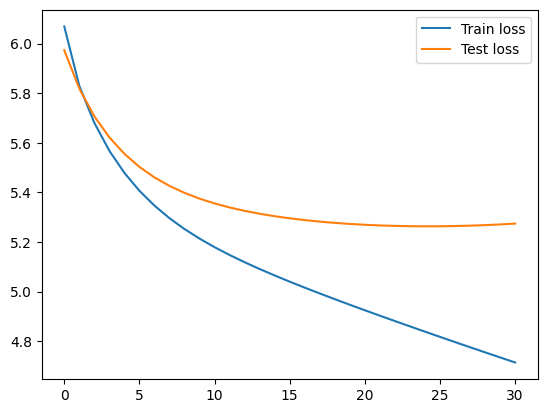

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.show()